In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

In [3]:
plt_width = plt_height = 16
matplotlib.rcParams['figure.figsize'] = [plt_width, plt_height]
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
def get_image(path, img_transforms, size = (300, 300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)
    
def get_gram(m): 
    """
    m shape: (1,C,H,W)
    """
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t())
    return m

def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def plot_images(images, line_size = 4):
    fig, axs = plt.subplots(len(images) // line_size + int(len(res_images) % line_size > 0), line_size)
    for idx, image in enumerate(images):
        row = idx // line_size
        col = idx %  line_size
        axs[row, col].imshow(images[idx])
        if idx == 0:
            axs[row, col].set_title('Image')
        elif idx == len(images)-1:
            axs[row, col].set_title('Style')
        else:
            axs[row, col].set_title('Result - '+str(idx))
    fig.tight_layout()
    plt.show()

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]  #  layers of style to perserve
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_feats = []
        for layer_num, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_num) in self.selected_layers:
                layer_feats.append(x)
        return layer_feats
            

In [6]:
def run_transfer_style(content_img, style_img, generated_img, encoder, optimizer, epochs = 2000, result_size = 10):
    alpha = 0.01; beta = 100000
    images = []
    for epoch in range(epochs):
        content_features = encoder(content_img)
        style_features = encoder(style_img)
        generated_features = encoder(generated_img)

        content_loss = torch.mean((content_features[-1] - generated_features[-1]) ** 2)

        style_loss = 0
        for gf, sf in zip(generated_features, style_features):
            _, c, h, w = gf.size()
            gram_gf = get_gram(gf)
            gram_sf = get_gram(sf)
            style_loss += torch.mean((gram_gf - gram_sf)**2) / (c * h * w)

        loss = alpha * content_loss + beta * style_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % (epochs // result_size) == 0 or epoch == 0:
            print("Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss:{:.4f}".format(epoch, content_loss.item(), style_loss.item()))
            inp = generated_img.detach().cpu().squeeze()
            inp = denormalize_img(inp)
            images.append(inp)
            
    return images

Epoch [0]	Content Loss: 0.0000	Style Loss:3030.4849
Epoch [665]	Content Loss: 3.4044	Style Loss:126.7449
Epoch [1331]	Content Loss: 3.8066	Style Loss:46.3764
Epoch [1997]	Content Loss: 4.0272	Style Loss:22.4758
Epoch [2663]	Content Loss: 4.1297	Style Loss:14.4189
Epoch [3329]	Content Loss: 4.2019	Style Loss:10.5361
Epoch [3995]	Content Loss: 4.2577	Style Loss:8.1500


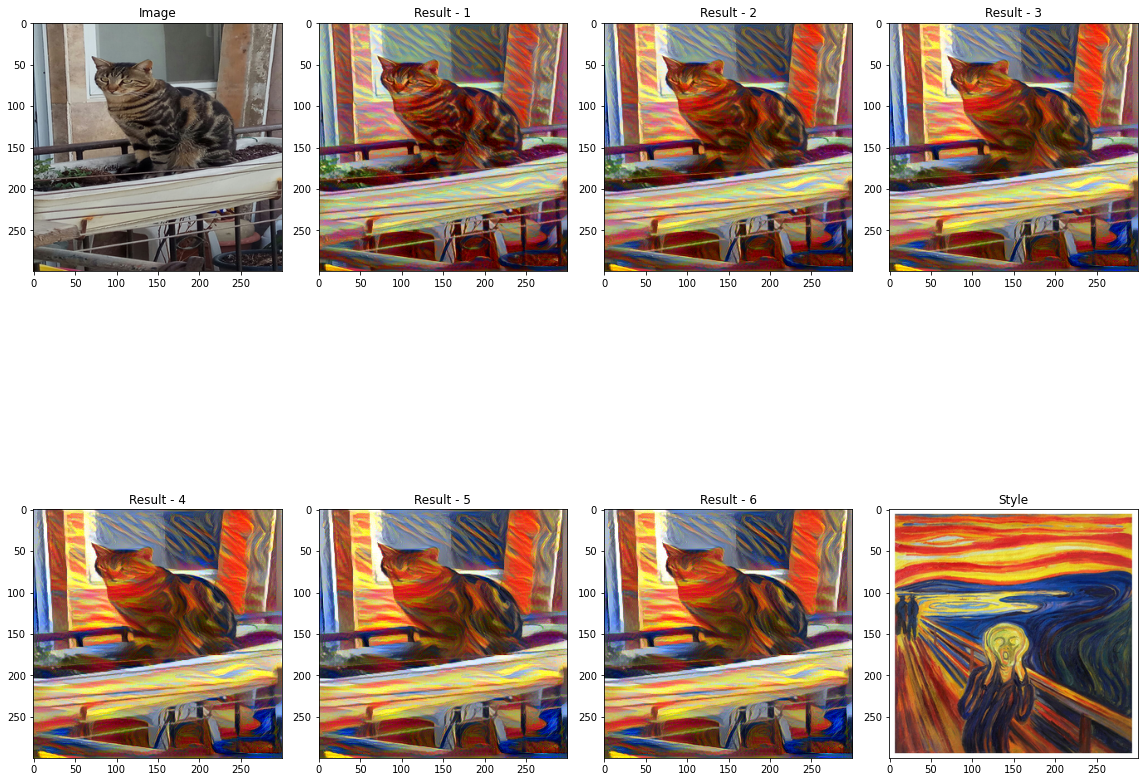

In [9]:
photos = ['./NST/Jul_3.jpg'] # ['./NST/Jul_1.jpg', './NST/Jul_2.jpg']
styles = ['./NST/style_scream.jpg'] # ['./NST/style_gogh.jpg', './NST/style_glass.jpg', './NST/style_liza.jpg', './NST/style_scream.jpg']
for photo in photos:
    for style in styles:
        img_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
        content_img = get_image(photo, img_transform, size=(300, 300))
        style_img = get_image(style, img_transform, size=(300, 300))

        generated_img = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))
        generated_img.requires_grad = True

        optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
        encoder = FeatureExtractor().to(device)

        for p in encoder.parameters():
            p.requires_grad = False
        
        res_images = run_transfer_style(content_img=content_img, style_img=style_img, generated_img=generated_img, 
                           encoder=encoder, optimizer=optimizer, epochs = 4000, result_size = 6)
        
        inp = style_img.detach().cpu().squeeze()
        inp = denormalize_img(inp)
        res_images.append(inp)
        
        plot_images(images=res_images)
        


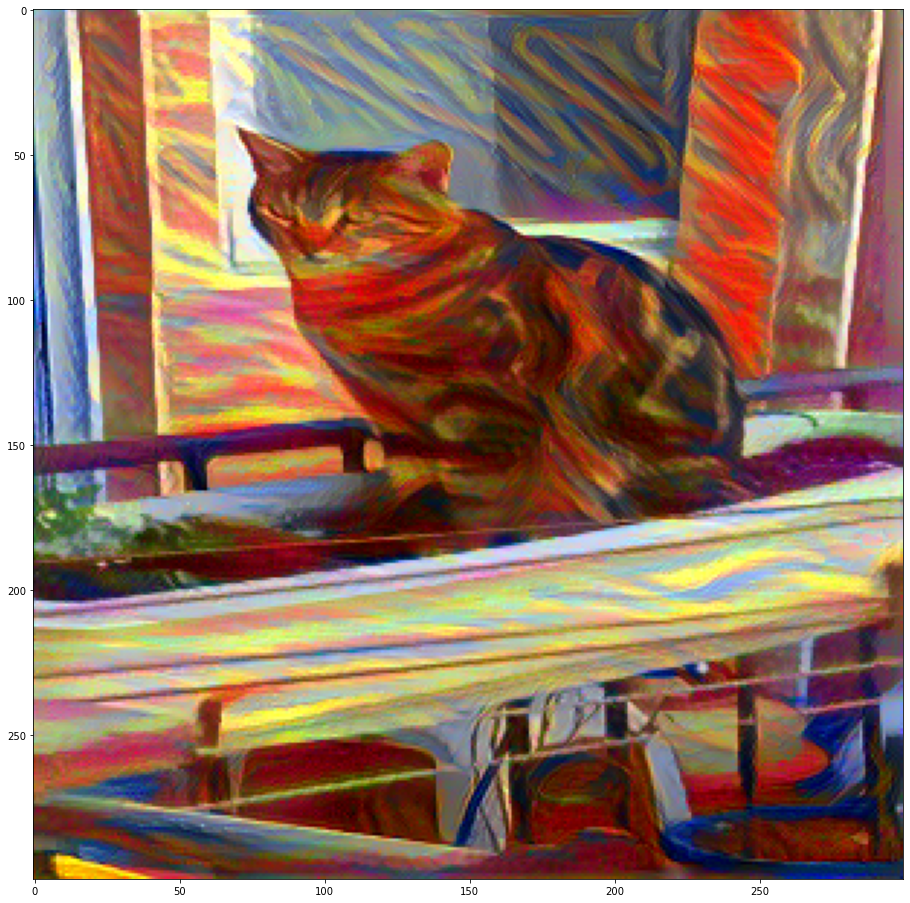

In [11]:
plt.imshow(res_images[2])
plt.show()